# Recommendation System

You will be making movie recommendations based on the <a href="https://grouplens.org/datasets/movielens/latest/">MovieLens dataset</a> from the GroupLens research lab at the University of Minnesota. Unless you are planning to run your analysis on a paid cloud platform, we recommend that you use the "small" dataset containing 100,000 user ratings (and potentially, only a particular subset of that dataset).

Your task is to:

    Build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.

The MovieLens dataset is a "classic" recommendation system dataset, that is used in numerous academic papers and machine learning proofs-of-concept. You will need to create the specific details about how the user will provide their ratings of other movies, in addition to formulating a more specific business problem within the general context of "recommending movies".

#### Collaborative Filtering
At minimum, your recommendation system must use collaborative filtering. If you have time, consider implementing a hybrid approach, e.g. using collaborative filtering as the primary mechanism, but using content-based filtering to address the <a href="https://en.wikipedia.org/wiki/Cold_start_(recommender_systems)">cold start</a> problem.

#### Evaluation
The MovieLens dataset has explicit ratings, so achieving some sort of evaluation of your model is simple enough. But you should give some thought to the question of metrics. Since the rankings are ordinal, we know we can treat this like a regression problem. But when it comes to regression metrics there are several choices: RMSE, MAE, etc. Here are some further ideas.

## Import Packages

In [1]:
import zipfile
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

import pyspark
from pyspark.sql import SparkSession

# import pyspark.sql.functions
from pyspark.sql.functions import col, min, max, avg

from pyspark.ml.recommendation import ALS

# Import RegressionEvaluator
from pyspark.ml.evaluation import RegressionEvaluator

# Import ParamGridBuilder, CrossValidator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Start a spark session
spark = SparkSession.builder.getOrCreate()

## Import Data

In [2]:
# Download the data

# ! wget -P ../../data http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [3]:
# Unzip the data

# with zipfile.ZipFile('../../data/ml-latest-small.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data')

## Data exploration & manipulation

In [56]:
# Read in the data with spark DataFrames
links = spark.read.csv('../../data/ml-latest-small/links.csv', inferSchema=True, header=True)
movies = spark.read.csv("../../data/ml-latest-small/movies.csv", inferSchema=True, header=True)
ratings = spark.read.csv("../../data/ml-latest-small/ratings.csv", inferSchema=True, header=True)
tags = spark.read.csv("../../data/ml-latest-small/tags.csv", inferSchema=True, header=True)
# tags = tags.select('userId', 'movieId', 'tag')

# Join tabels
df = ratings.join(movies, ["movieID"], "left")
df = df.join(tags, ["userID", "movieID"], "left")

df.show()

# df = ratings.join(tags, ["userId", "movieId"], "left")
# df = df.join(movies, ["movieId"], "left")

# #Convert to Pandas Dataframe and filter columns
# pandas_df=df.toPandas()
# pandas_df = pandas_df[['userId', 'rating', 'movieId', 'title', 'genres', 'tag', 'timestamp']]

# # Fill null tags with "Unkown"
# pandas_df.tag = pandas_df.tag.fillna("Uknown")

# # LabelEncode tags and genres
# le = LabelEncoder()
# le_genres = LabelEncoder()
# tags_le = le.fit_transform(pandas_df.tag)
# genres_le = le_genres.fit_transform(pandas_df.genres)

# pandas_df = pandas_df.drop(['genres', 'tag'], axis=1)
# pandas_df['tags_le'] = pd.Series(tags_le, index=pandas_df.index).astype(str)
# pandas_df['genres_le'] = pd.Series(genres_le, index=pandas_df.index).astype(str)

# # Convert back Spark Dataframe
# df = spark.createDataFrame(pandas_df)

# # Change dtypes from strings to numeric
# df = df.select(df.userId.cast("integer"),
#                df.movieId.cast("integer"),
#                df.rating.cast("double"),
#                df.genres_le.cast("integer"),
#                df.tags_le.cast("integer"),
#                df.timestamp.cast("integer"),
#                df.title)

+------+-------+------+---------+--------------------+--------------------+----+---------+
|userId|movieId|rating|timestamp|               title|              genres| tag|timestamp|
+------+-------+------+---------+--------------------+--------------------+----+---------+
|     1|      1|   4.0|964982703|    Toy Story (1995)|Adventure|Animati...|null|     null|
|     1|      3|   4.0|964981247|Grumpier Old Men ...|      Comedy|Romance|null|     null|
|     1|      6|   4.0|964982224|         Heat (1995)|Action|Crime|Thri...|null|     null|
|     1|     47|   5.0|964983815|Seven (a.k.a. Se7...|    Mystery|Thriller|null|     null|
|     1|     50|   5.0|964982931|Usual Suspects, T...|Crime|Mystery|Thr...|null|     null|
|     1|     70|   3.0|964982400|From Dusk Till Da...|Action|Comedy|Hor...|null|     null|
|     1|    101|   5.0|964980868|Bottle Rocket (1996)|Adventure|Comedy|...|null|     null|
|     1|    110|   4.0|964982176|   Braveheart (1995)|    Action|Drama|War|null|     null|

In [41]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: integer (nullable = true)



In [42]:
df.show(10)

+------+-------+------+---------+--------------------+--------------------+----+---------+
|userId|movieId|rating|timestamp|               title|              genres| tag|timestamp|
+------+-------+------+---------+--------------------+--------------------+----+---------+
|     1|      1|   4.0|964982703|    Toy Story (1995)|Adventure|Animati...|null|     null|
|     1|      3|   4.0|964981247|Grumpier Old Men ...|      Comedy|Romance|null|     null|
|     1|      6|   4.0|964982224|         Heat (1995)|Action|Crime|Thri...|null|     null|
|     1|     47|   5.0|964983815|Seven (a.k.a. Se7...|    Mystery|Thriller|null|     null|
|     1|     50|   5.0|964982931|Usual Suspects, T...|Crime|Mystery|Thr...|null|     null|
|     1|     70|   3.0|964982400|From Dusk Till Da...|Action|Comedy|Hor...|null|     null|
|     1|    101|   5.0|964980868|Bottle Rocket (1996)|Adventure|Comedy|...|null|     null|
|     1|    110|   4.0|964982176|   Braveheart (1995)|    Action|Drama|War|null|     null|

#### Calculating Sparsity

In [43]:
# Count the total number of ratings in the dataset
numerator = df.select("rating").count()

# Count the number of distinct userIds and distinct movieIds
num_users = df.select("userId").distinct().count()
num_movies = df.select("movieId").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of movies
denominator = num_users * num_movies

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  98.27% empty.


#### Ratings Summary Statistics

In [44]:
# Min num ratings for movies
print("Movie with the fewest ratings: ")
df.groupBy("movieID").count().select(min("count")).show()

# Avg num ratings per movie
print("Avg num ratings per movie: ")
df.groupBy("movieID").count().select(avg("count")).show()

# Min num ratings for user
print("User with the fewest ratings: ")
df.groupBy("userID").count().select(min("count")).show()

# Avg num ratings per users
print("Avg num ratings per user: ")
df.groupBy("userID").count().select(avg("count")).show()

print("Num of users: " + str(df.groupBy("userID").count().count()))
print("Num of movies: " + str(df.groupBy("movieID").count().count()))
print("Num of tags: " + str(df.groupBy("tag").count().count()))

print("Num of rows in ratings: " + str(ratings.count()))

print("Num of rows in tags: " + str(tags.count()))

print("Num of rows in combined dataframe: " + str(df.count()))

Movie with the fewest ratings: 
+----------+
|min(count)|
+----------+
|         1|
+----------+

Avg num ratings per movie: 
+------------------+
|        avg(count)|
+------------------+
|10.559132044426162|
+------------------+

User with the fewest ratings: 
+----------+
|min(count)|
+----------+
|        20|
+----------+

Avg num ratings per user: 
+------------------+
|        avg(count)|
+------------------+
|168.32295081967214|
+------------------+

Num of users: 610
Num of movies: 9724
Num of tags: 1544
Num of rows in ratings: 100836
Num of rows in tags: 3683
Num of rows in combined dataframe: 102677


# Modeling

#### FSM

In [45]:
# Split the ratings dataframe into training and test data
(training_data, test_data) = df.randomSplit([.8, .2])

# Set the ALS hyperparameters
als_fsm = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", nonnegative =True, implicitPrefs = False)

# Fit the model to the training_data
fsm = als_fsm.fit(training_data)

# Generate predictions on the test_data
test_predictions = fsm.transform(test_data)
test_predictions.show(10)

+------+-------+------+----------+--------------------+------+---------+----------+----------+
|userId|movieId|rating| timestamp|               title|genres|      tag| timestamp|prediction|
+------+-------+------+----------+--------------------+------+---------+----------+----------+
|   133|    471|   4.0| 843491793|Hudsucker Proxy, ...|Comedy|     null|      null| 2.5719693|
|   474|    471|   3.0| 974668858|Hudsucker Proxy, ...|Comedy|hula hoop|1137375547| 3.2929633|
|   462|    471|   2.5|1123890831|Hudsucker Proxy, ...|Comedy|     null|      null| 2.8910556|
|   176|    471|   5.0| 840109075|Hudsucker Proxy, ...|Comedy|     null|      null| 3.3042927|
|   448|    471|   4.0|1178980875|Hudsucker Proxy, ...|Comedy|     null|      null| 3.3557544|
|    32|    471|   3.0| 856737165|Hudsucker Proxy, ...|Comedy|     null|      null| 3.7903266|
|   608|    471|   1.5|1117161794|Hudsucker Proxy, ...|Comedy|     null|      null|  2.447992|
|   609|    833|   3.0| 847221080|High School High

#### Build RMSE evaluator

In [46]:
# Complete the evaluator code
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [47]:
# Evaluate the "test_predictions" dataframe
RMSE = evaluator.evaluate(test_predictions)

# Print the RMSE
print (RMSE)

0.8751853412231582


#### Tuning Hyperparameters

In [48]:
# # Create ALS model
# als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
#           coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)

In [49]:
# Add hyperparameters and their respective values to param_grid
# param_grid = ParamGridBuilder() \
#             .addGrid(als.alpha, [0, .25, .5, .75, 1]) \
#             .addGrid(als.rank, [10, 25, 50, 75, 100]) \
#             .addGrid(als.regParam, [.05, .1, .15, .2]) \
#             .addGrid(als.maxIter, [5, 25, 50, 75, 100]) \
#             .build()


# print length of evaluator
# print ("Num models to be tested: ", len(param_grid))

In [50]:
# Build cross validation using CrossValidator
# cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

In [51]:
# Fit cross validator to the 'train' dataset
# model = cv.fit(train)

In [52]:
# Extract best model from the cv model above
# best_model = model.bestModel

In [27]:
# Complete the code below to extract the ALS model parameters
# print("**Best Model**")

# rank: 50
# regParam=0.15
# alpha=0

# Print "ParamMap"
# print("\n\n  ParamMap:", best_model._java_obj.parent().extractParamMap())

In [58]:
# New model with best params
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          alpha=0, rank=50, regParam=0.15, maxIter=10,
          coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)
# Fit model to train
model = als.fit(training_data)

# Use mode to predict on test
test_predictions = model.transform(test_data)
test_predictions.show(10)

+------+-------+------+----------+--------------------+--------------------+----+---------+----------+
|userId|movieId|rating| timestamp|               title|              genres| tag|timestamp|prediction|
+------+-------+------+----------+--------------------+--------------------+----+---------+----------+
|   599|    471|   2.5|1498518822|Hudsucker Proxy, ...|              Comedy|null|     null| 2.7002628|
|   520|    471|   5.0|1326609921|Hudsucker Proxy, ...|              Comedy|null|     null| 3.5689154|
|   171|    471|   3.0| 866905683|Hudsucker Proxy, ...|              Comedy|null|     null| 4.2534246|
|   273|    471|   5.0| 835861348|Hudsucker Proxy, ...|              Comedy|null|     null| 3.8096783|
|   287|    471|   4.5|1110231536|Hudsucker Proxy, ...|              Comedy|null|     null| 2.8891737|
|   541|    471|   3.0| 835643551|Hudsucker Proxy, ...|              Comedy|null|     null| 3.5029209|
|   357|    471|   3.5|1348627082|Hudsucker Proxy, ...|              Come

In [59]:
# Evaluate the "test_predictions" dataframe
RMSE = evaluator.evaluate(test_predictions)

# Print the RMSE
print (RMSE)

0.8558909829884935


## Final recommendations

In [214]:
# Make 5 movie recommendations per user using their highest predicted ratings
recommendations = model.recommendForAllUsers(5)
# Print Some Prediction
recommendations.registerTempTable("ALS_recs_temp")
clean_recs = spark.sql("SELECT userId, movieIds_and_ratings.movieId AS movieId, movieIds_and_ratings.rating AS prediction FROM ALS_recs_temp LATERAL VIEW explode(recommendations) exploded_table AS movieIds_and_ratings")
clean_recs = clean_recs.join(movies, on=['movieId'], how='left').sort('userId')
clean_recs.show()

+-------+------+----------+--------------------+--------------------+
|movieId|userId|prediction|               title|              genres|
+-------+------+----------+--------------------+--------------------+
|  33649|     1| 5.6744037|  Saving Face (2004)|Comedy|Drama|Romance|
|  78836|     1|  5.412517|Enter the Void (2...|               Drama|
|   5466|     1|  5.528956|My Wife is an Act...|Comedy|Drama|Romance|
|   6442|     1|  5.395703| Belle époque (1992)|      Comedy|Romance|
| 132333|     1|  5.518676|         Seve (2014)|   Documentary|Drama|
| 158872|     2| 4.5820627|Sausage Party (2016)|    Animation|Comedy|
|   5466|     2|  4.644174|My Wife is an Act...|Comedy|Drama|Romance|
|  33649|     2|  4.661236|  Saving Face (2004)|Comedy|Drama|Romance|
|  89774|     2|  4.616292|      Warrior (2011)|               Drama|
| 131724|     2| 4.8352394|The Jinx: The Lif...|         Documentary|
|   5919|     3| 4.7393913|      Android (1982)|              Sci-Fi|
|   5746|     3|  4.

In [ ]:
# put in a random user number and return list of 5 titles
clean_recs

### Content Base Model

In [193]:
tags_pd = pd.read_csv("../../data/ml-latest-small/tags.csv")
movies_pd = pd.read_csv("../../data/ml-latest-small/movies.csv")
content_pd = movies_pd.merge(tags_pd, on = "movieId")

# Separate the words in the genres column
content_pd['genres'] = content_pd['genres'].str.replace('|',' ')

# Since we have multiple tags for some movies from different users,
# we will make a combined tags column to combine those different tags for each movie
# and make a dataframe that has one row per movie
movie_Ids = content_pd.movieId.unique()
for movie in movie_Ids:
    m = content_pd[content_pd.movieId == movie]
    t = ""
    for x in m.values:
        if x[4] not in t:
            t+= x[4]+" "
    content_pd.loc[content_pd['movieId']==movie, 'combined_tags']=t
    
    
content_pd = content_pd[['movieId', 'title', 'genres', 'combined_tags']]
content_pd.drop_duplicates(inplace=True)
content_pd.reset_index(inplace=True)

In [194]:
content_pd.head()

,index,movieId,title,genres,combined_tags
0,0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar fun
1,3,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams
2,7,3,Grumpier Old Men (1995),Comedy Romance,moldy
3,9,5,Father of the Bride Part II (1995),Comedy,pregnancy remake
4,11,7,Sabrina (1995),Comedy Romance,remake


In [195]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

features = ['genres','combined_tags']

def combine_features(row):
    return row['genres'] +" "+row['combined_tags']

for feature in features:
    content_pd[feature] = content_pd[feature].fillna('')
    
content_pd["combined_features"] = content_pd.apply(combine_features,axis=1)

cv = CountVectorizer()
count_matrix = cv.fit_transform(content_pd["combined_features"])

cosine_sim = cosine_similarity(count_matrix)

def get_title_from_index(index):
    return content_pd[content_pd.index == index]["title"].values[0]

def get_index_from_title(title):
    return content_pd[content_pd.title == title].index[0]

movie_user_likes = "Jumanji (1995)"
movie_index = get_index_from_title(movie_user_likes)
similar_movies =  list(enumerate(cosine_sim[movie_index]))
sorted_similar_movies = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:]
i=0

print("Top 5 similar movies to "+movie_user_likes+" are:\n")

for element in sorted_similar_movies:
    print(get_title_from_index(element[0]))
    i=i+1
    if i>=5:
        break

Top 5 similar movies to Jumanji (1995) are:

Lord of the Rings: The Fellowship of the Ring, The (2001)
Harry Potter and the Chamber of Secrets (2002)
Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)
Chronicles of Narnia: Prince Caspian, The (2008)
Sinbad: Legend of the Seven Seas (2003)


In [241]:
len(content_pd)

1572

In [230]:
movie_genres = content_pd.genres.unique()

In [231]:
movie_genres = " ".join(movie_genres)

In [238]:
from nltk.tokenize import word_tokenize
from collections import Counter

word_tokens = word_tokenize(movie_genres)
stopset = ['no', 'genres', 'listed', '(', ')']
cleanup = [token for token in word_tokens if token not in stopset]
bow = Counter(cleanup)

In [266]:
bow_dict = dict(bow)

In [339]:
bow_df = (pd.DataFrame.from_dict(bow_dict, orient='index', columns=["count"]))
bow_df.sort_values('count', ascending=False, inplace=True)
bow_df.reset_index(inplace=True)
bow_df.columns=['Genre', 'Movie Count']

In [316]:
bow_df

,Genre,Count
0,Drama,152
1,Comedy,119
2,Adventure,113
3,Action,109
4,Thriller,99
5,Fantasy,82
6,Romance,82
7,Sci-Fi,78
8,Crime,71
9,Animation,70


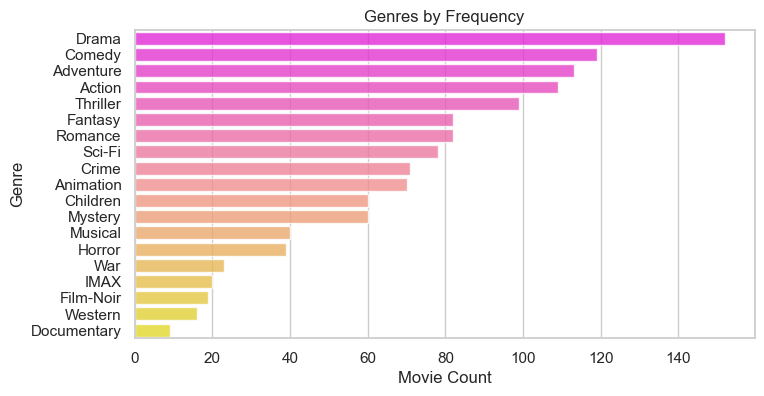

In [340]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.style.use('default')
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x=bow_df['Movie Count'], y=bow_df['Genre'], alpha=.8, palette='spring')
ax.set(title = 'Genres by Frequency');